In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

f10=pynbody.load("snapshot_099")

# Boltzmann constant
kB=pynbody.array.SimArray(np.zeros(1))
kB[0]=1.38e-23
kB.sim=f10
kB.units='J K**-1'
# A simpler way?
    
# Planck constant
h=pynbody.array.SimArray(np.zeros(1))
h[0]=6.63e-34
h.sim=f10
h.units='J s'

np.random.seed(57)
normalize=np.random.normal(size=(len(f10),3))

In [2]:
def entropy_iso(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process

    norm1=f.dm.kdtree.sph_mean(normalize)
    norm2=f.dm.kdtree.sph_mean((normalize-norm1)**2)
    
    nx=norm2[:,0]
    ny=norm2[:,1]
    nz=norm2[:,2]
    
    norm=(nx+ny+nz)/3
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    vel_disp=f.dm.kdtree.sph_mean((vel-f.dm.kdtree.sph_mean(vel))**2)
    
    vx_disp=vel_disp[:,0]
    vy_disp=vel_disp[:,1]
    vz_disp=vel_disp[:,2]

    v_disp=(vx_disp+vy_disp+vz_disp)/3
    
    v_disp=v_disp/norm
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    a=((2*np.pi)**(3/2))*(mass_dm.in_units('kg')**3)*np.sqrt(v_disp)**3
    b=a/n_density/(h**3)*(np.e**(5/2))
    sv=kB*n_density*np.log(b.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    f.dm['S_iso']=S
    f.dm['sv_iso']=sv

In [3]:
def entropy_ani(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process
    
    dnorm=normalize-f.dm.kdtree.sph_mean(normalize)
    
    dnormx=dnorm[:,0]
    dnormy=dnorm[:,1]
    dnormz=dnorm[:,2]
    
    n2_xx=f.dm.kdtree.sph_mean(dnormx**2)
    n2_yy=f.dm.kdtree.sph_mean(dnormy**2)
    n2_zz=f.dm.kdtree.sph_mean(dnormz**2)
    
    n2_xy=f.dm.kdtree.sph_mean(dnormx*dnormy)
    n2_yz=f.dm.kdtree.sph_mean(dnormy*dnormz)
    n2_zx=f.dm.kdtree.sph_mean(dnormz*dnormx)
    
    norm6=n2_xx*(n2_yy*n2_zz-n2_yz**2)-n2_xy*(n2_xy*n2_zz-n2_yz*n2_zx)+n2_zx*(n2_xy*n2_yz-n2_yy*n2_zx)
    norm=norm6**(1/3)
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    dvel=vel-f.dm.kdtree.sph_mean(vel)
    dvx=dvel[:,0]
    dvy=dvel[:,1]
    dvz=dvel[:,2]
    
    disp_xx=f.dm.kdtree.sph_mean(dvx**2)
    disp_yy=f.dm.kdtree.sph_mean(dvy**2)
    disp_zz=f.dm.kdtree.sph_mean(dvz**2)
    
    disp_xy=f.dm.kdtree.sph_mean(dvx*dvy)
    disp_yz=f.dm.kdtree.sph_mean(dvy*dvz)
    disp_zx=f.dm.kdtree.sph_mean(dvz*dvx)
    
    det_disp=disp_xx*(disp_yy*disp_zz-disp_yz**2)-disp_xy*(disp_xy*disp_zz-disp_yz*disp_zx)+disp_zx*(disp_xy*disp_yz-disp_yy*disp_zx)
    det=det_disp**(1/3)
    
    det=det/norm
    
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    a=((2*np.pi)**(3/2))*(mass_dm.in_units('kg')**3)*np.sqrt(det)**3
    b=a/n_density/(h**3)*(np.e**(5/2))
    b.units='1'
    sv=kB*n_density*np.log(b.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    f.dm['S_ani']=S
    f.dm['sv_ani']=sv

In [4]:
def calculate(f):
    entropy_iso(f)
    entropy_ani(f)
    f.dm['dsv']=f.dm['sv_iso']-f.dm['sv_ani']
    f.dm['dS']=f.dm['S_iso']-f.dm['S_ani']

In [5]:
calculate(f10)

The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated


In [6]:
res=2000

rhoplot=pynbody.plot.image(f10, qty='rho',units='kg m**-3',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)

Sisoplot=pynbody.plot.image(f10, qty='S_iso',units='J K**-1',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)
Saniplot=pynbody.plot.image(f10, qty='S_ani',units='J K**-1',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)
dSplot=pynbody.plot.image(f10, qty='dS',units='J K**-1',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)

svisoplot=pynbody.plot.image(f10, qty='sv_iso',units='J K**-1 m**-3',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)
svaniplot=pynbody.plot.image(f10, qty='sv_ani',units='J K**-1 m**-3',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)
dsvplot=pynbody.plot.image(f10, qty='dsv',units='J K**-1 m**-3',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)

In [7]:
def sv(fra,shr,fs):
    
    plt.figure(figsize=(27,10))
    
    def cb(x,pos):
        return 10**x
    
    plt.subplot(1,3,1)
    plt.imshow(np.log10(svisoplot),vmin=-24,vmax=-18)
    cb1=plt.colorbar(fraction=fra,shrink=shr,format=ticker.FuncFormatter(cb),orientation='horizontal')
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.title("Isotropic",fontsize=3/2*fs)
    
    cb1.set_label('$s\\ (J/K\\ m^{-3})$',fontsize=fs)
    cb1.ax.tick_params(labelsize=fs)
    
    
    
    plt.subplot(1,3,2)
    plt.imshow(np.log10(svaniplot),vmin=-24,vmax=-18)
    cb2=plt.colorbar(fraction=fra,shrink=shr,format=ticker.FuncFormatter(cb),orientation='horizontal')
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.title("Anisotropic",fontsize=3/2*fs)
    
    cb2.set_label('$s\\ (J/K\\ m^{-3})$',fontsize=fs)
    cb2.ax.tick_params(labelsize=fs)
    
    
    
    plt.subplot(1,3,3)
    plt.imshow(np.log10(dsvplot),cmap='bwr',vmin=-27,vmax=-21)
    cb3=plt.colorbar(fraction=fra,shrink=shr,format=ticker.FuncFormatter(cb),orientation='horizontal')
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.title("Difference",fontsize=3/2*fs)
    
    cb3.set_label('$s\\ (J/K\\ m^{-3})$',fontsize=fs)
    cb3.ax.tick_params(labelsize=fs)
    
    plt.savefig('EpV results 10.pdf',bbox_inches='tight',pad_inches=0.0)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


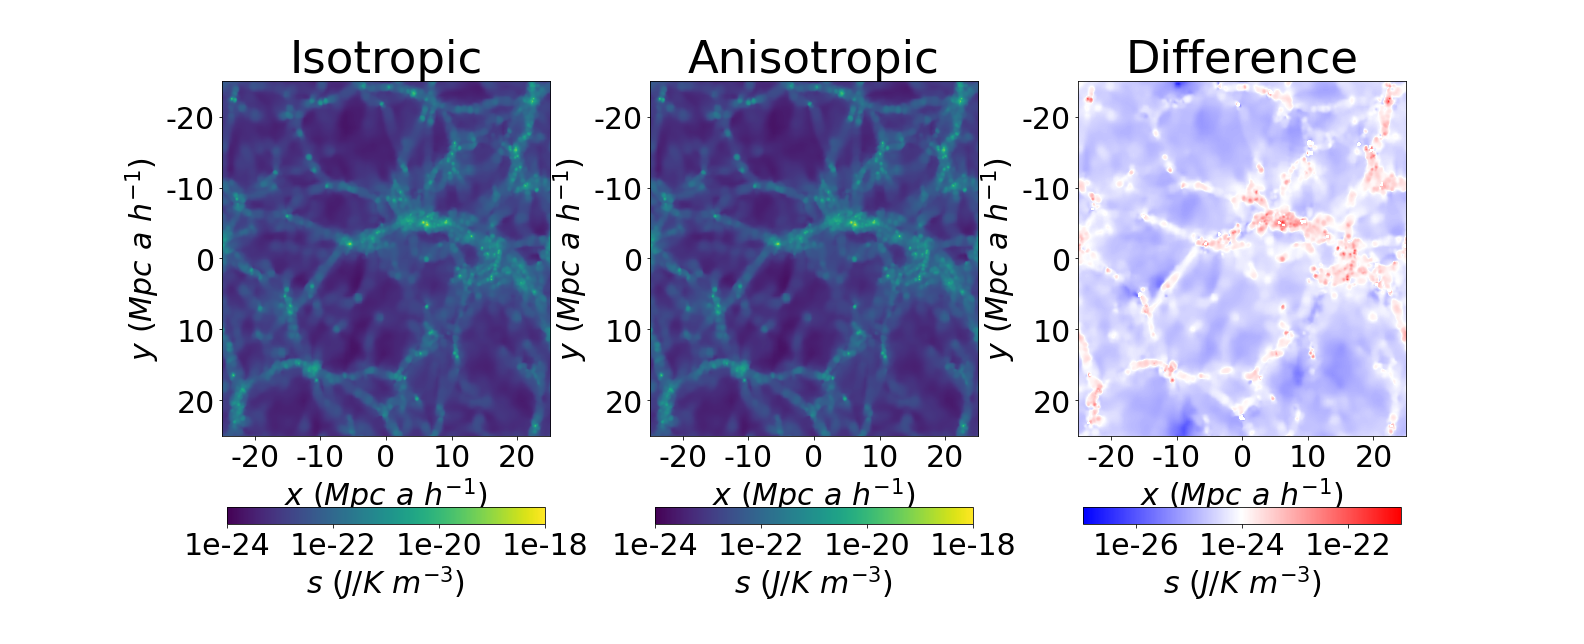

In [8]:
sv(0.1,0.89,30)

In [9]:
def S(fra,shr,fs):
    
    plt.figure(figsize=(27,10))
    
    plt.subplot(1,3,1)
    plt.imshow(Sisoplot*1e+21,vmin=1.25,vmax=1.4)
    cb1=plt.colorbar(fraction=fra,shrink=shr,orientation='horizontal')
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.title("Isotropic",fontsize=3*fs/2)
    
    cb1.set_label('S (1e-21 J/K)',fontsize=fs)
    cb1.ax.tick_params(labelsize=fs)
    
    ######################################################################################
    
    plt.subplot(1,3,2)
    plt.imshow(Saniplot*1e+21,vmin=1.25,vmax=1.4)
    cb2=plt.colorbar(fraction=fra,shrink=shr,orientation='horizontal')
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.title("Anisotropic",fontsize=3*fs/2)
    
    cb2.set_label('S (1e-21 J/K)',fontsize=fs)
    cb2.ax.tick_params(labelsize=fs)
    
    ######################################################################################
    
    plt.subplot(1,3,3)
    plt.imshow(dSplot*1e+23,cmap='bwr',vmin=0,vmax=8)
    cb3=plt.colorbar(fraction=fra,shrink=shr,orientation='horizontal')
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=fs)
    plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=fs)
    plt.title("Difference",fontsize=3*fs/2)
    
    cb3.set_label('S (1e-23 J/K)',fontsize=fs)
    cb3.ax.tick_params(labelsize=fs)
    
    ######################################################################################
    
    plt.savefig('EpP results 10.pdf',bbox_inches='tight',pad_inches=0.0)

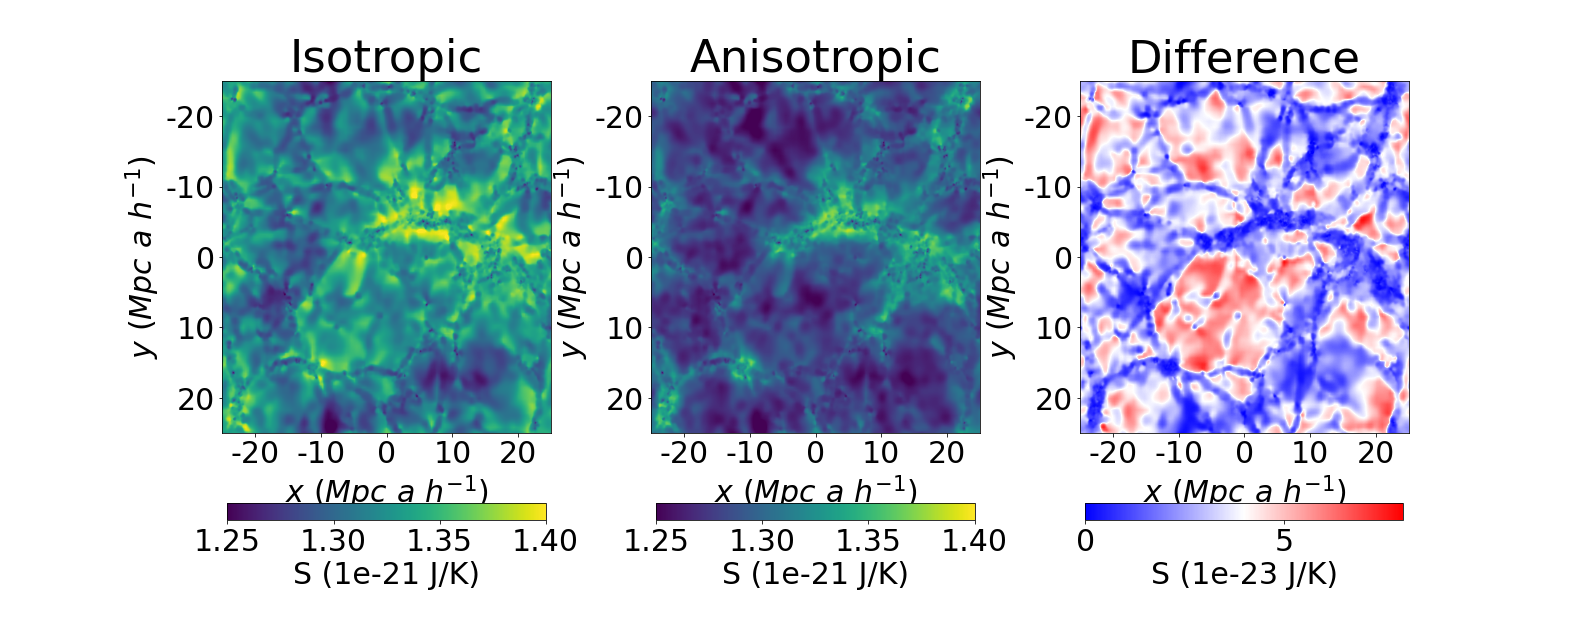

In [10]:
S(0.1,0.89,30)

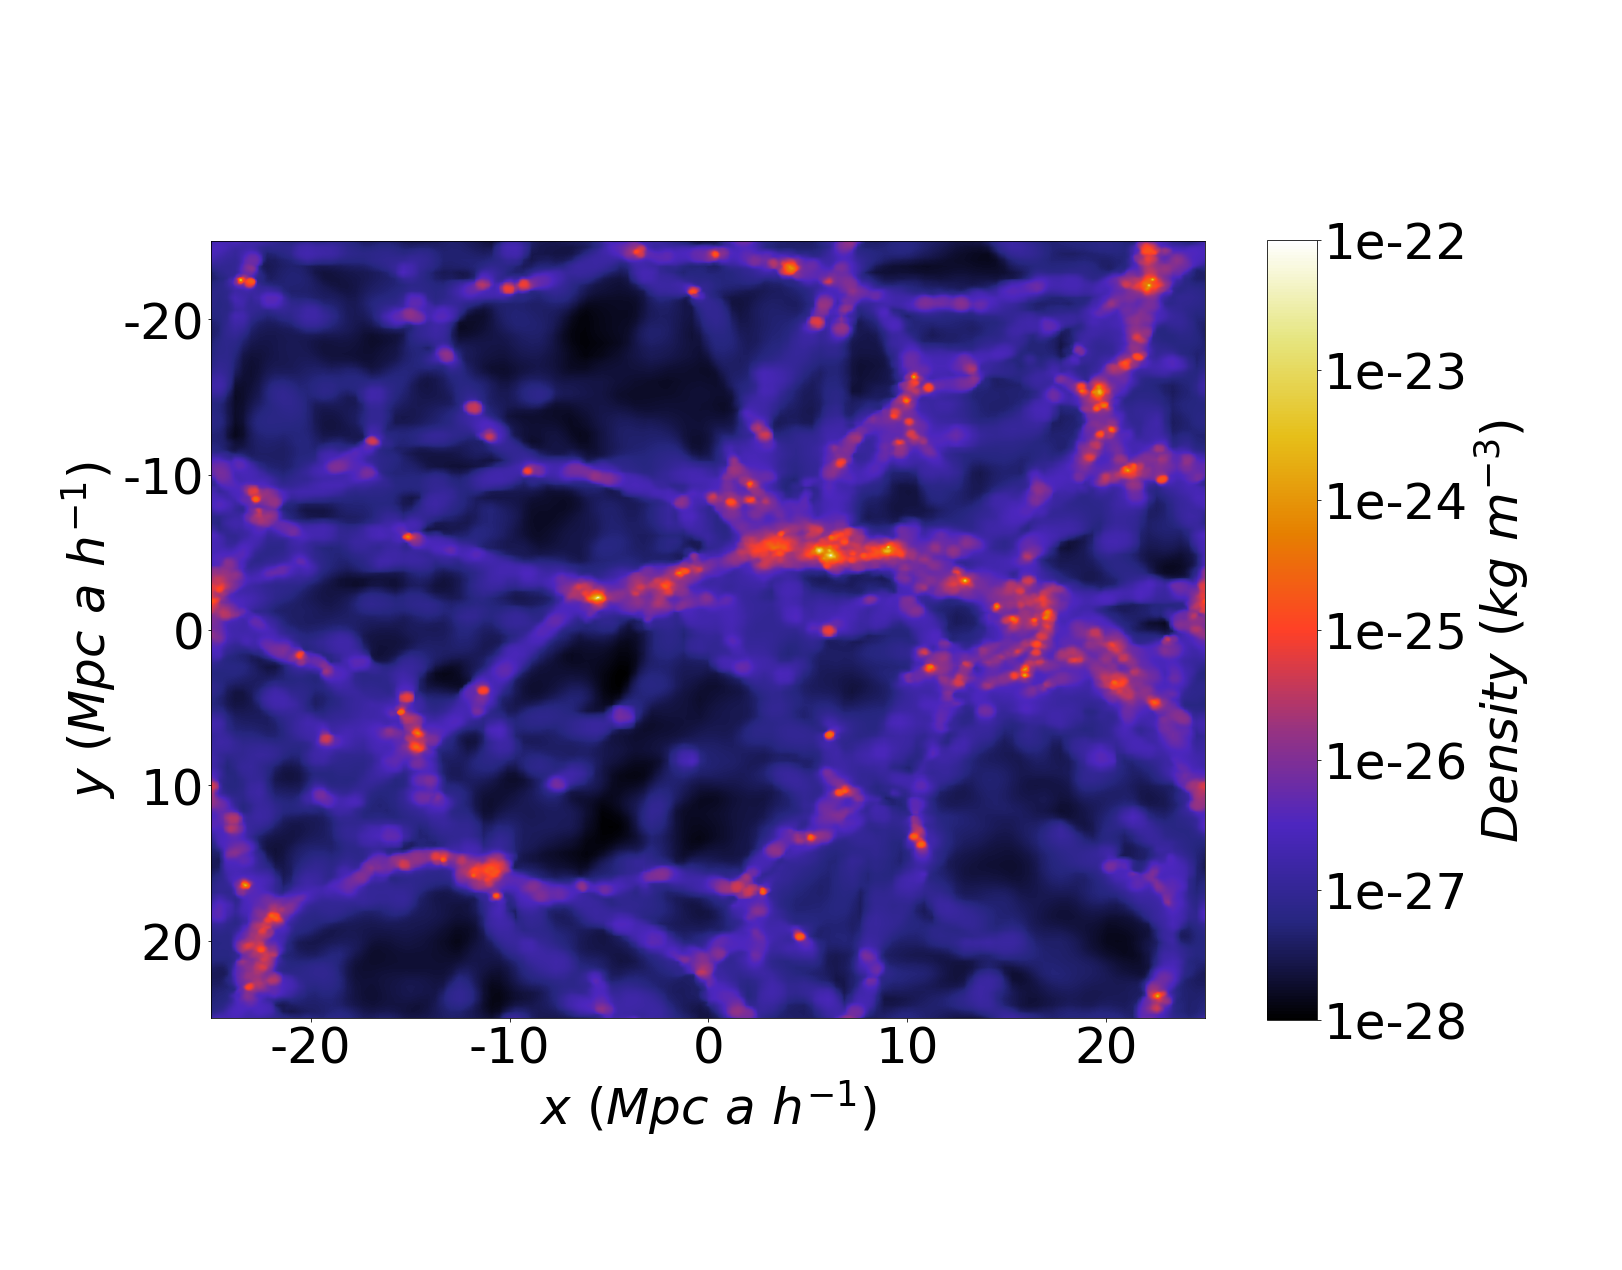

In [11]:
def cb(x,pos):
        return 10**x

plt.figure(figsize=(25,25))
plt.subplot(111)
plt.imshow(np.log10(rhoplot),cmap='CMRmap',vmin=-28,vmax=-22)
cbr=plt.colorbar(shrink=0.825,format=ticker.FuncFormatter(cb))
plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=50)
plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=50)
plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=50)
plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=50)

cbr.set_label('$Density\\ (kg\\ m^{-3})$',fontsize=50)
cbr.ax.tick_params(labelsize=50)

plt.savefig('Density10.pdf',bbox_inches='tight',pad_inches=0.0)